In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = "/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/"

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec")

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from datetime import datetime

import os
import yaml
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense
from tensorflow.keras.layers import Dropout
import holidays
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from Model_Data_preparation import *
from Model import *
from evaluate import *
from Comparison_framework_LSTM import *






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# # Load the config file
with open("/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/config_data.yaml", "r") as yamlfile:
    config_data = yaml.load(yamlfile, Loader=yaml.FullLoader)
    #print("Read successful")
print(config_data)


# # Initialize the variables
zone_name = config_data['zone']

# zonal_data_path = config_data['zonal_data_path']

val_days = config_data['val_days']
Test_Days = config_data['Test_Days']
num_frequencies = config_data['num_frequencies']
hours_lookback = config_data['hours_lookback']
epochs = 300
batches = 8

{'zonal_data_path': '/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/demand_zonal/', 'weather_data_path': '/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/Weather/lux_weather_hourly_smoothened.csv', 'model_filepath': 'my_best_model.hdf5', 'start_date': '2016-01-30 23:00:00', 'end_date': '2019-09-01 00:00:00', 'wavelet_function': 'mexh', 'num_frequencies': 24, 'Train_Days': 830, 'val_days': 120, 'Test_Days': 120, 'pred_window': 24, 'hours_lookback': 24, 'zone': 'lu_cleaned_hourly_demand_smoothened_18_07'}


In [ ]:





model_data, model_targets, df_demand_en,min_elec, max_elec = model_input_prep(zone_name, config_data)


# Prepares the model input, model target, the dataset as dataframe, and returns minimum and maximum values for deonrmalization at the end

# Train-test-split data as per the days mentioned in config
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(model_data, model_targets, val_days, Test_Days)


# Model

# Initialize the model
nCh = model_data.shape[3]
model = model_structure(num_frequencies, hours_lookback, nCh)
print(model.summary())



# Train the model, change the batch size and epoch in the argument
model, history = train_model(model, X_train, y_train, X_val, y_val, epoch=epochs, batch_size=batches)



# Make prediction using the saved model


result_df1 = make_prediction(zone_name, df_demand_en, model, history, X_test, y_test,  min_elec, max_elec,config_data)

metrics_df = get_metrics(result_df1, config_data['Test_Days'], config_data['pred_window'])
metrics_df.to_csv()
print('metrics_df:',metrics_df)










days: 1070
x: (1070, 24)
y: (1070, 24)
[436.5 406.5 390.5 ... 408.  387.  424. ]
(31413,)
[0.45923871 0.41300663 0.38834951 ... 0.41531823 0.38295577 0.43997534]
(31413,)
x: (1070, 24)
y: (1070, 24)
xwh: (1070, 24, 24, 5)
XX: (1070, 24, 24, 1)
y-test: (120, 24)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        1472      
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_5 (Dense)             (None, 2048)              1

In [ ]:


import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import holidays
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense
from tensorflow.keras.layers import Dropout




df_demand_en = pd.read_csv('/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/demand_zonal/lu_cleaned_hourly_demand.csv')
#df_demand_en = pd.read_csv("/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/demand_zonal/lu_cleaned_15min_demand.csv")

df_demand_en['Datetime'] = pd.to_datetime(df_demand_en['Datetime'])
df_demand_en = df_demand_en.set_index('Datetime')
start_date = '2016-01-30 23:00:00' #start date of analysis
end_date = '2019-09-01 00:00:00' #end date of analysis
# hours_lookback = 24
# Select DataFrame rows between two dates
mask = (df_demand_en.index > start_date) & (df_demand_en.index <= end_date)
df_demand_en = df_demand_en.loc[mask]

df_weather = pd.read_csv('/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/Weather/lux_weather_hourly.csv')
#df_weather = pd.read_csv('/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/Weather/luxembourg_15mins.csv')

# weather_data = df_weather.drop(['timezone', 'city_name', 'lat', 'lon', 'pressure','sea_level','grnd_level', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all', 'weather_id','weather_main','weather_description','weather_icon'], axis = 1)
df_weather.index = pd.to_datetime(df_weather['dt_iso'])

# weather_temp = weather_data.drop(['dt_iso'], axis=1)
# df_weather.drop_duplicates(keep=False,inplace=True)

temperature_data = pd.DataFrame(df_weather['feelslike'],columns = ['feelslike'])
# temperature_data = df_weather[['feelslike']]

df_demand_en = pd.merge(df_demand_en, temperature_data, left_index=True, right_index=True)
# join the table of demand and temperature data



df_demand_en = df_demand_en.rename(columns={"em": "cons"})
# df_demand_en = df_demand_en.dropna() #droping the first row with NaN generated for differencing

df_demand_en = df_demand_en.reset_index()  # index turns to new column "index"

df_demand_en["DayOfWeek"] = df_demand_en["index"].dt.weekday
# extract day of week from the dates,dt: access datetime measures, weekday gives integer (0monday to 6 sunday)

dayofweek = df_demand_en['DayOfWeek'].values

for ii in range(len(dayofweek)):
  if dayofweek[ii]>4:
      dayofweek[ii]=1
  else:
      dayofweek[ii]=0


df_demand_en['HolidayOrWeekend'] = dayofweek
df_demand_en['Date'] = df_demand_en['index'].dt.date
lu_holidays = holidays.LU()  # get the list of holidays for Luxembourgh
holiday = np.zeros(len(df_demand_en))
for ii in range(len(df_demand_en['Date'].values)):
    Date = df_demand_en['Date'].values[ii]
    isHoliday = lu_holidays.get(Date)  # checking which of the dates in our dataframe are there in holdiay-list dates
    if isHoliday != None:
        holiday[ii] = 1
df_demand_en['HolidayOrWeekend'] = df_demand_en['HolidayOrWeekend'].values + holiday  # combining weekends with holidays
df_demand_en["HolidayOrWeekend"] = np.where(df_demand_en["HolidayOrWeekend"] > 0, 1, 0)

# Train_Days = 730
# val_days = 180
# Test_Days = 180+120

Train_Days = 830
val_days = 120
Test_Days = 120


days = Train_Days + val_days + Test_Days



mu = df_demand_en['cons'].mean()
print(mu)
sigma = df_demand_en['cons'].std()
print(sigma)
mu+sigma




elec = df_demand_en['cons'].head(1090*hours_lookback).values #1090:total days
for ii in range(len(elec)):
    if elec[ii]>2*(mu+sigma):
        elec[ii] = elec[ii-1]


min_elec = elec.min()
max_elec = elec.max()




X = np.zeros((days,hours_lookback))
y = np.zeros((days,hours_lookback))
W = np.zeros((days,hours_lookback))
Wf = np.zeros((days,hours_lookback))

##incorporating holiday
H = np.zeros((days,hours_lookback))
Hf = np.zeros((days,hours_lookback))

holiday = df_demand_en['HolidayOrWeekend'].values

elec = df_demand_en['cons'].values
for ii in range(len(elec)):
  if elec[ii]>2*(mu+sigma):
      elec[ii] = elec[ii-1]

elec = (elec-elec.min())/(elec.max()-elec.min())


weather = df_demand_en['feelslike'].values
weather = (weather-weather.min())/(weather.max()-weather.min())
for ii in range(days):
  X[ii] = elec[ii*hours_lookback:ii*hours_lookback+hours_lookback]
  y[ii] = elec[(ii+1)*hours_lookback:(ii+1)*hours_lookback+hours_lookback]
  W[ii] = weather[(ii)*hours_lookback:(ii)*hours_lookback+hours_lookback]
  Wf[ii] = weather[(ii+1)*hours_lookback:(ii+1)*hours_lookback+hours_lookback]
  H[ii] = holiday[(ii)*hours_lookback:(ii)*hours_lookback+hours_lookback]
  Hf[ii] = holiday[(ii+1)*hours_lookback:(ii+1)*hours_lookback+hours_lookback]


X=X.reshape((X.shape[0],X.shape[1],1))
y=y.reshape((y.shape[0],y.shape[1],1))
W=W.reshape((W.shape[0],W.shape[1],1))
Wf=Wf.reshape((Wf.shape[0],Wf.shape[1],1))
H=H.reshape((H.shape[0],H.shape[1],1))
Hf=Hf.reshape((Hf.shape[0],Hf.shape[1],1))



XWH = np.concatenate((X,W,Wf, H, Hf), axis=2)
# XWH = np.concatenate((X,H,Hf), axis=2)
XWH.shape




y.shape







#days = Train_Days + int(val_ratio*Train_Days) + Test_Days
days = Train_Days + val_days + Test_Days





train_split = val_days+Test_Days

X_train  = XWH[:-train_split] #Get the training features
X_test = XWH[-train_split:] #Get the testingresult_df feature

y_train = y[:-train_split] #Get the training target sequences
y_test = y[-train_split:] #Get the testing+validation sequences

y_val = y_test[:-val_days] #Get the validation output sequences
X_val = X_test[:-val_days] #Get the validation input sequences

X_test = X_test[-Test_Days:] #Get the testing input sequences
y_test = y_test[-Test_Days:]  #Get the testing output sequences


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.models import load_model
filepath='/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/my_best_lstm_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Define the EarlyStopping callback to stop training if the validation loss does not improve for a certain number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

# Define the learning rate for the optimizer
learning_rate = 0.001

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Define the list of callbacks
callbacks = [checkpoint, early_stopping]

# LSTM with 50 units are chosen by iteratively choosing [10,20,30,40,50,60..100] hidden units and checking which returns the best validation score. After the choice is made, the loop is removed from the same notebook because with that present, the later part of load_model was hanging the system.

# In[42]:


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dense(hours_lookback))
model.compile(loss='mse', optimizer='adam')
# fit network
history2 = model.fit(X_train, y_train, epochs=epochs, batch_size=batches, validation_data=(X_val, y_val), verbose=2, shuffle=False, callbacks=callbacks)



###############################for choosing best hidden units#################
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.models import load_model

# filepath = 'my_best_lstm_model.hdf5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# callbacks = [checkpoint]

# hidden_units = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# best_score = 0
# best_model = None

# for units in hidden_units:
#     # Build the LSTM model
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(tf.keras.layers.Dense(hours_lookback))
#     model.compile(loss='mse', optimizer='adam')

#     # Train the model
#     history2 = model.fit(X_train, y_train, epochs=epochs, batch_size=7, validation_data=(X_val, y_val),
#                         verbose=2, shuffle=False, callbacks=callbacks)

#     # Get the best validation score
#     val_score = max(history2.history['val_loss'])
#     print(f"Hidden units: {units}, Validation Loss: {val_score}")

#     # Update the best model if necessary
#     if val_score < best_score or best_score == 0:
#         best_score = val_score
#         best_model = load_model(filepath)

# print(f"Best model hidden units: {best_model.layers[0].units}, Best Validation Loss: {best_score}")
################################


# In[43]:


model = load_model(filepath)


# In[44]:


y_pred = model.predict(X_test)
Y = y_test#.flatten()
Y_hat = np.abs(y_pred)#.flatten())

true_demand = (Y.flatten() * (max_elec - min_elec)) + min_elec  # inverse scalaring the ground truth
pred_demand = (Y_hat.flatten() * (max_elec - min_elec)) + min_elec  # inverse scalaring predictions

result_df = df_demand_en.head((Train_Days+val_days+Test_Days)*hours_lookback).tail(Test_Days*hours_lookback)
result_df['cons_pred'] = pred_demand #predicted demand in the result dataframe
result_df['cons'] = true_demand

#metrics
pred_window = hours_lookback

mape_pred_demand= np.zeros(Test_Days)
#demand_size = np.zeros(180)
rmse_pred_demand= np.zeros(Test_Days)
for ii in range(Test_Days):
  mape_pred_demand[ii] = 100*mape(result_df.cons.values[ii*pred_window:ii*pred_window+pred_window], result_df.cons_pred.values[ii*pred_window:ii*pred_window+pred_window]) #computing accuracy = (1-MAPE)*100%
  rmse_pred_demand[ii] = np.sqrt(mse(result_df.cons.values[ii*pred_window:ii*pred_window+pred_window], result_df.cons_pred.values[ii*pred_window:ii*pred_window+pred_window])) #computing RMSE

# print('mape:',mape_pred_demand)
# print('rmse:',rmse_pred_demand)

metrics_df = pd.DataFrame(mape_pred_demand, columns = ['pred_demand_acc'])
metrics_df['pred_demand_rmse'] = rmse_pred_demand
metrics_df['pred_demand_mape'] = mape_pred_demand
metrics_df.to_csv('/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/error_metrics_outputs/'+current_datetime+'_window'+str(pred_window)+'_LSTM.csv')





479.2385636519912
95.02414139974975
Epoch 1/300

Epoch 1: val_loss improved from inf to 0.02471, saving model to /content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/my_best_lstm_model.hdf5
104/104 - 3s - loss: 0.0524 - val_loss: 0.0247 - 3s/epoch - 32ms/step
Epoch 2/300

Epoch 2: val_loss improved from 0.02471 to 0.02358, saving model to /content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/my_best_lstm_model.hdf5
104/104 - 0s - loss: 0.0125 - val_loss: 0.0236 - 467ms/epoch - 4ms/step
Epoch 3/300

Epoch 3: val_loss improved from 0.02358 to 0.02295, saving model to /content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/my_best_lstm_model.hdf5
104/104 - 0s - loss: 0.0118 - val_loss: 0.0230 - 499ms/epoch - 5ms/step
Epoch 4/300

Epoch 4: val_loss improved from 0.02295 to 0.02246, saving model to /content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/my_best_lstm_model.hdf5
104/104 - 0s - loss: 0.0114 - val_loss: 0.0225 - 473ms/epoch - 5ms/step
Epoch 5/300

Epoch 5: val_loss improve

In [ ]:
result_df1.rename(columns={'index': 'dt_iso'}, inplace=True)
result_df.rename(columns={'index': 'dt_iso'}, inplace=True)


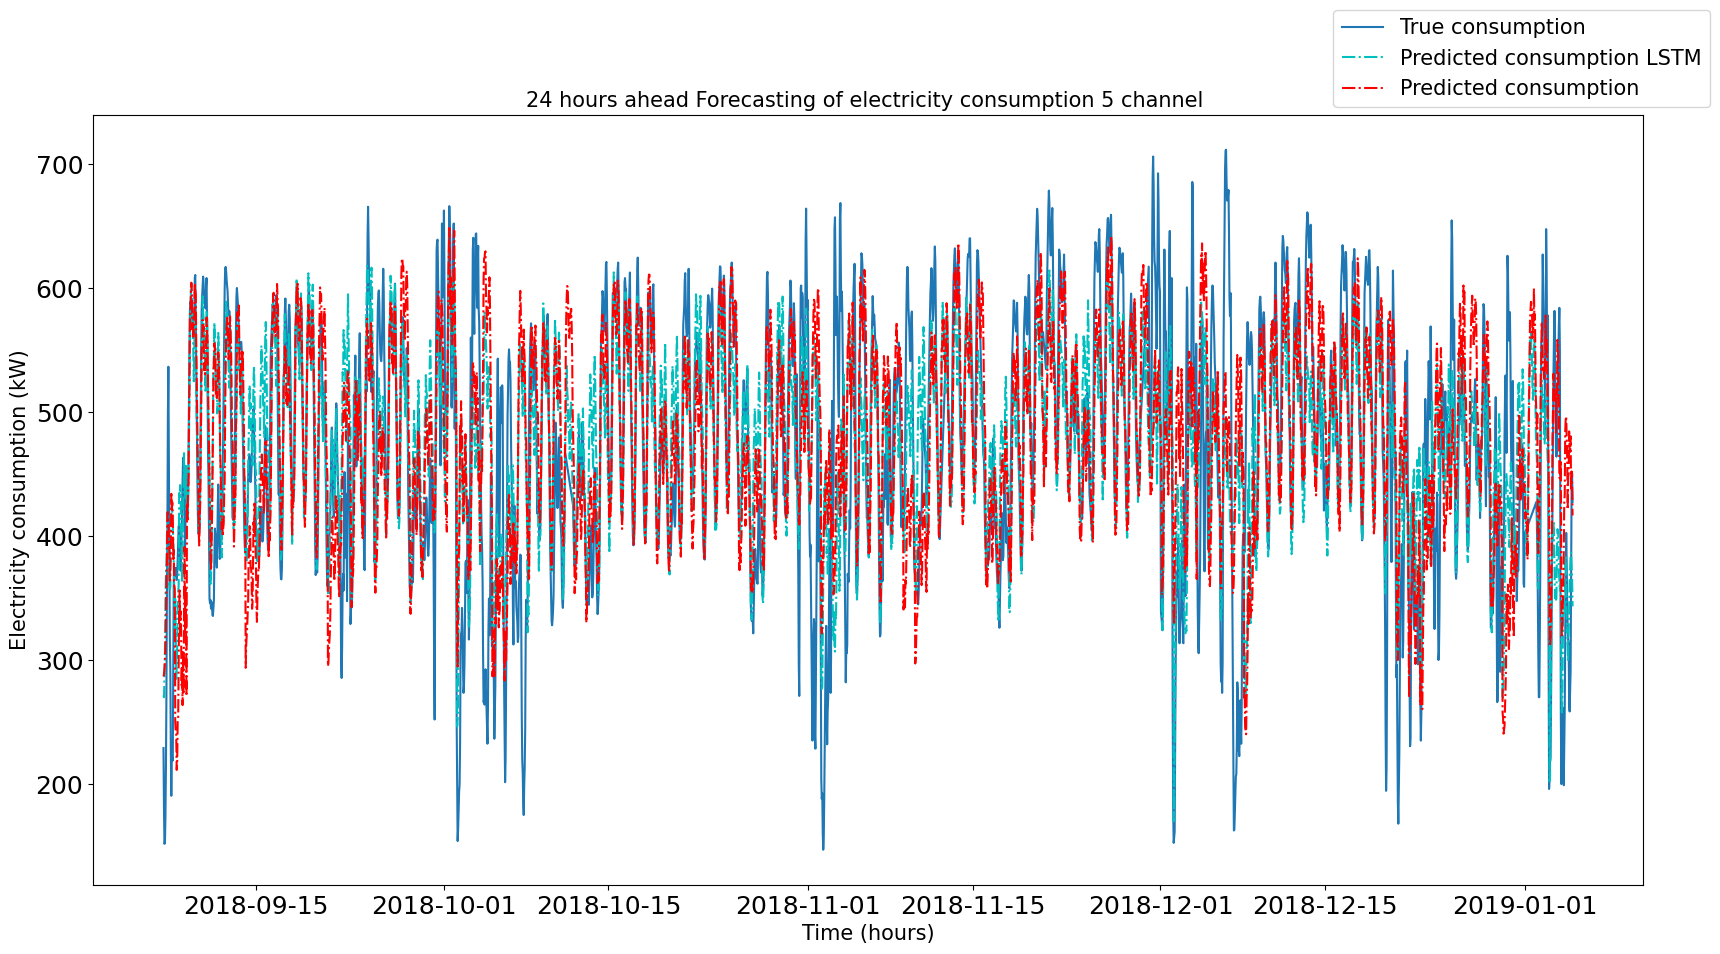

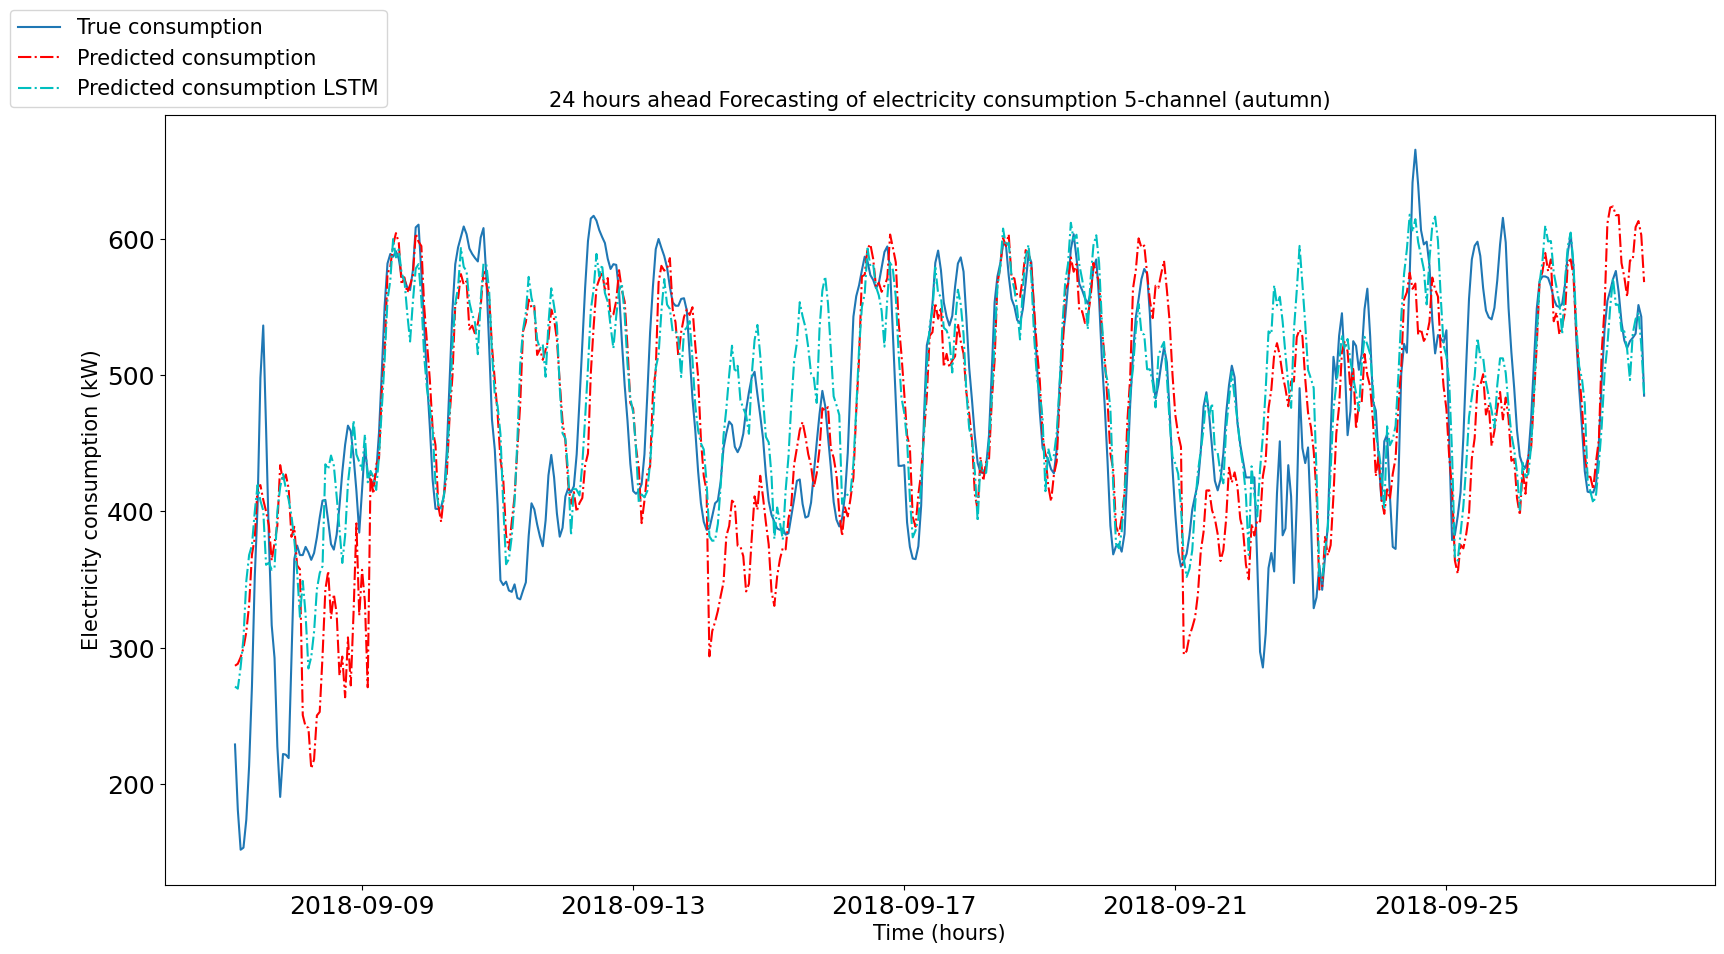

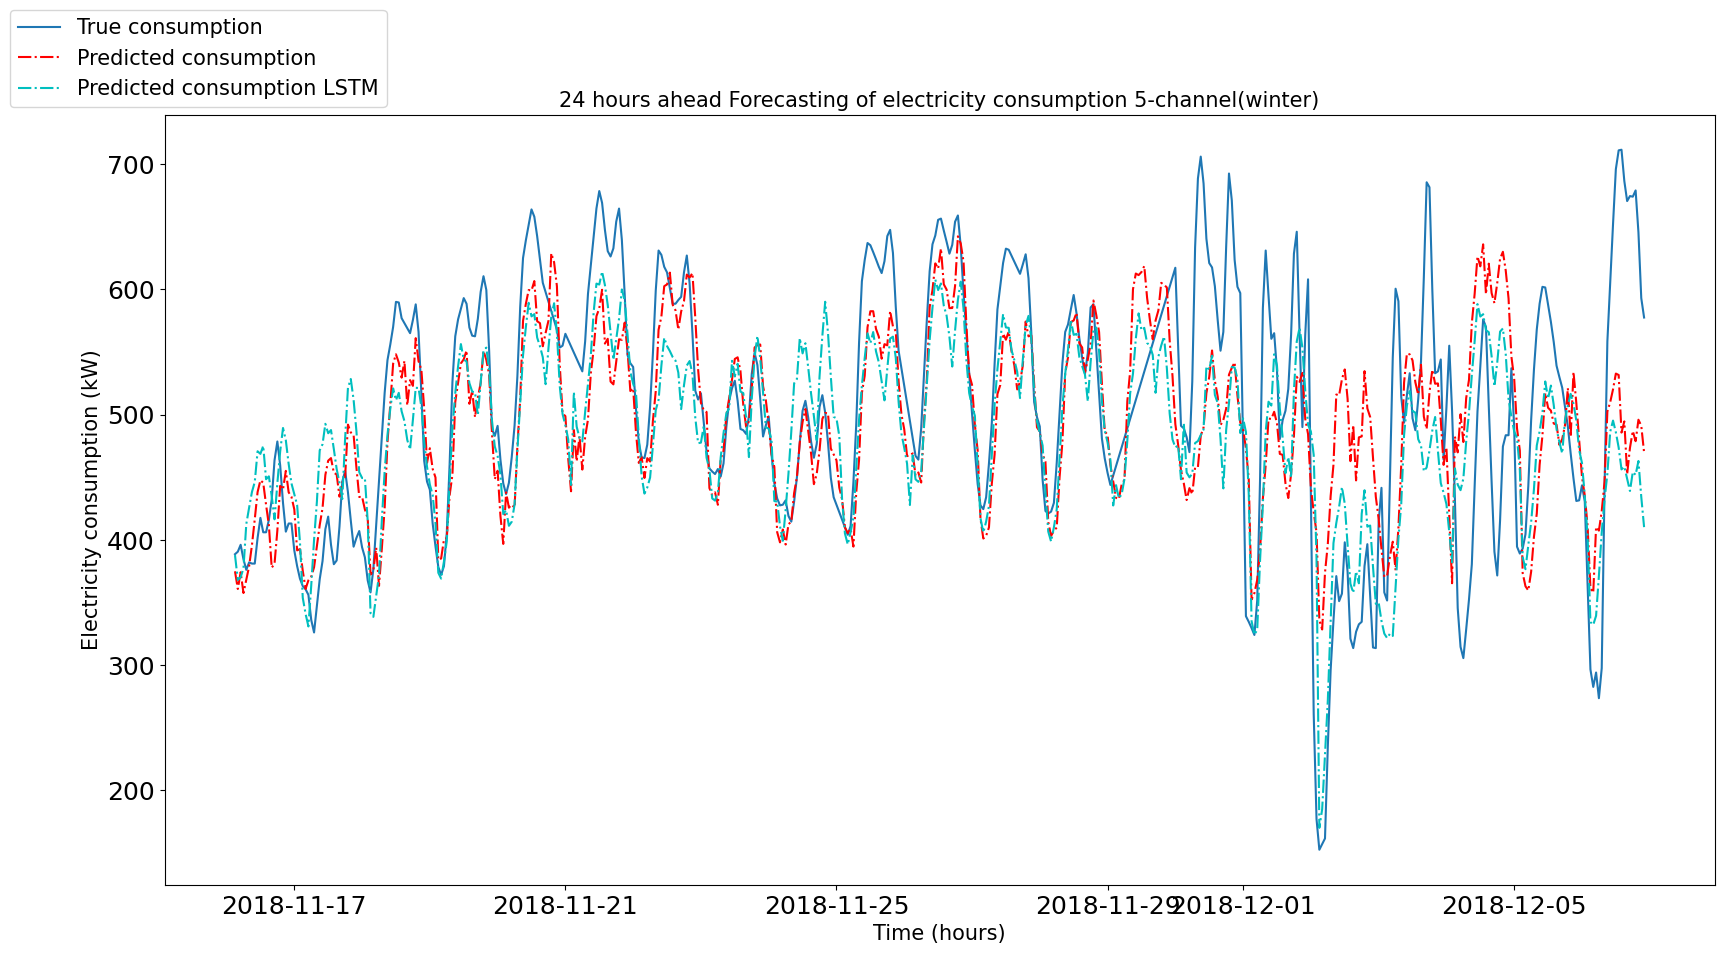

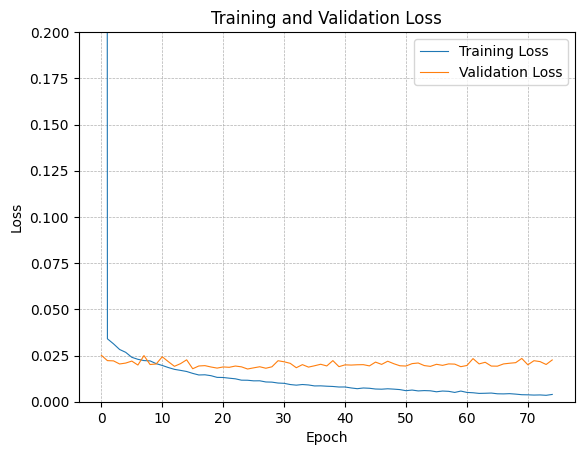

In [ ]:


############## from above ##################

current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S") # Get current datetime as a string
plt.figure(figsize=(20,10))


# Convert 'Datetime' column to datetime format
result_df1['dt_iso'] = pd.to_datetime(result_df1['dt_iso'])
result_df['dt_iso'] = pd.to_datetime(result_df['dt_iso'])


plt.plot(result_df1.dt_iso, result_df1.cons, label='True consumption')
plt.plot(result_df1.dt_iso,result_df.cons_pred , linestyle='dashdot',label='Predicted consumption LSTM', color='c')
plt.plot(result_df1.dt_iso, result_df1.cons_pred , linestyle='dashdot',label='Predicted consumption', color='red')


# plt.plot(result_df12.cons_pred , linestyle='dashdot',label='LSTM Predicted consumption', color='cyan')
plt.xlabel('Time (hours)', fontsize=15)
plt.ylabel('Electricity consumption (kW)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(0.15, 1.15),fontsize=15)

# plt.twinx()
# plt.plot(result_df1.feelslike , linestyle=':',label='Feel-like temperature', color='green')
# plt.ylabel('Feel-like temperature', fontsize=15)

plt.legend(bbox_to_anchor=(1.05, 1.15),fontsize=15)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('24 hours ahead Forecasting of electricity consumption 5 channel ', fontsize=15)
plt.savefig("/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/epred_outputs/epred_hourly_b" +str(batches) +"_"+ current_datetime + "_lookb" + str(hours_lookback) + "_ep"+str(epochs)+".png")
plt.show()

####################zoomed ouput1###########################
plt.figure(figsize=(20,10))
result_df11= result_df1.head(500)
result_df12= result_df.head(500)
plt.plot(result_df11.dt_iso, result_df11.cons, label='True consumption')
plt.plot(result_df11.dt_iso ,result_df11.cons_pred, linestyle='dashdot',label='Predicted consumption', color='red')
plt.plot(result_df12.dt_iso ,result_df12.cons_pred,linestyle='dashdot',label='Predicted consumption LSTM', color='c')

# plt.plot(result_df12.cons_pred , linestyle='dashdot',label='LSTM Predicted consumption', color='cyan')
plt.xlabel('Time (hours)', fontsize=15)
plt.ylabel('Electricity consumption (kW)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(0.15, 1.15),fontsize=15)
#plt.plot(np.abs(np.diff(Y_hat.flatten()))/50 ,label='Predicted', color='red')

# plt.twinx()
# plt.plot(result_df11.feelslike , linestyle=':',label='Feel-like temperature', color='green')
# plt.ylabel('Feel-like temperature', fontsize=15)
# plt.legend(bbox_to_anchor=(1.05, 1.15),fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('24 hours ahead Forecasting of electricity consumption 5-channel (autumn)', fontsize=15)
plt.savefig("/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/epred_outputs/epred_hourly_b"+str(batches)+"_"+current_datetime+"_lookb"+str(hours_lookback)+"_ep"+str(epochs)+"_zoomed.png")
plt.show()

########################################



# Plot the training and validation loss curves
import matplotlib.pyplot as plt


# Enable grid lines
plt.grid(True, linestyle='--', linewidth=0.5)

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss', linewidth=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=0.8)

# Setting plot limits and adding grid lines
plt.ylim(ymax=0.2, ymin=0)


# Adding title, labels, and legend
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Saving the plot with a grid structure
plt.savefig("/content/drive/MyDrive/proj_elec/Proj2/WavScaloNet_elec/epred_outputs/epred_hourly_b"+str(batches)+"_"+current_datetime+"_lookb"+str(hours_lookback)+"_ep"+str(epochs)+"_loss_grid.png", dpi=300)

# Displaying the plot
plt.show()



